In [310]:
;akleralsdkfdasfk;
import pandas as pd
import numpy as np

import re

from sklearn.preprocessing import StandardScaler
import math
import scipy.stats as st
from scipy.stats import bayes_mvs
from scipy.sparse import csr_matrix

from time import time
import copy
import pickle
import missingno as msno

import itertools
from collections import Counter
from collections import deque 

from parallel_pandas import ParallelPandas

from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

import scipy
from sklearn.utils import shuffle

from sklearn.manifold import TSNE

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from wordcloud import WordCloud, get_single_color_func

In [2]:
!ls

bayes_avg_eqn.png      interactions_train.csv	    RAW_recipes.csv
food_cluster.ipynb     interactions_validation.csv  README.md
food_EDA.ipynb	       PP_recipes.csv		    view_pkl.ipynb
ingr_map.pkl	       PP_users.csv
interactions_test.csv  RAW_interactions.csv


<h4><b>What is the Bayesian average?</b></h4>
The Bayesian average uses two constants to offset the arithmetic average of an individual product. This is important as otherwise products with only one five star rating are affoarding the same quality ranking as products with thousands of five star reviews. To account for differences in certainty, the rating for recipes with less than a critical number of reviews are adjusted, whlile recipes above this threshold are only very slightly adjusted. The critical value (C) is the number of reviews of the 25% quartile, which for our dataset is 1. The formula for the Bayesian average (r bar) is shown below where r and c are the rating and rating count for an individual recipe and C and R are critical threshold and average rating.

<h3></h3>
<h3>Importing data</h3>

In [3]:
def import_data():
    '''Import cleaned recipe, raw recipe and ratings data'''
    #cleaned recipes
    recipes = pd.read_csv('PP_recipes.csv')
    del recipes['i']
    del recipes['name_tokens']
    del recipes['ingredient_tokens']
    del recipes['steps_tokens']
    recipes = recipes.set_index('id')

    #ratings
    ratings = pd.read_csv('RAW_interactions.csv')
    del ratings['user_id']
    del ratings['date']
    del ratings['review']
    ratings = ratings.set_index('recipe_id')

    #raw recipe info
    raw_recipes = pd.read_csv('RAW_recipes.csv')
    del raw_recipes['contributor_id']
    del raw_recipes['submitted']
    del raw_recipes['tags']
    del raw_recipes['steps']
    del raw_recipes['description']
    raw_recipes = raw_recipes.set_index('id')

    return (recipes, raw_recipes, ratings)

In [4]:
recipes_, raw_recipes_, ratings_ = import_data()

In [5]:
recipes_.head()

,techniques,calorie_level,ingredient_ids
id,,,
424415,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",0,"[389, 7655, 6270, 1527, 3406]"
146223,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",0,"[2683, 4969, 800, 5298, 840, 2499, 6632, 7022,..."
312329,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",1,"[1257, 7655, 6270, 590, 5024, 1119, 4883, 6696..."
74301,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,"[7940, 3609, 7060, 6265, 1170, 6654, 5003, 3561]"
76272,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",0,"[3484, 6324, 7594, 243]"


In [6]:
ratings_.head()

,rating
recipe_id,
40893,4
40893,5
44394,4
85009,5
85009,5


<Axes: >

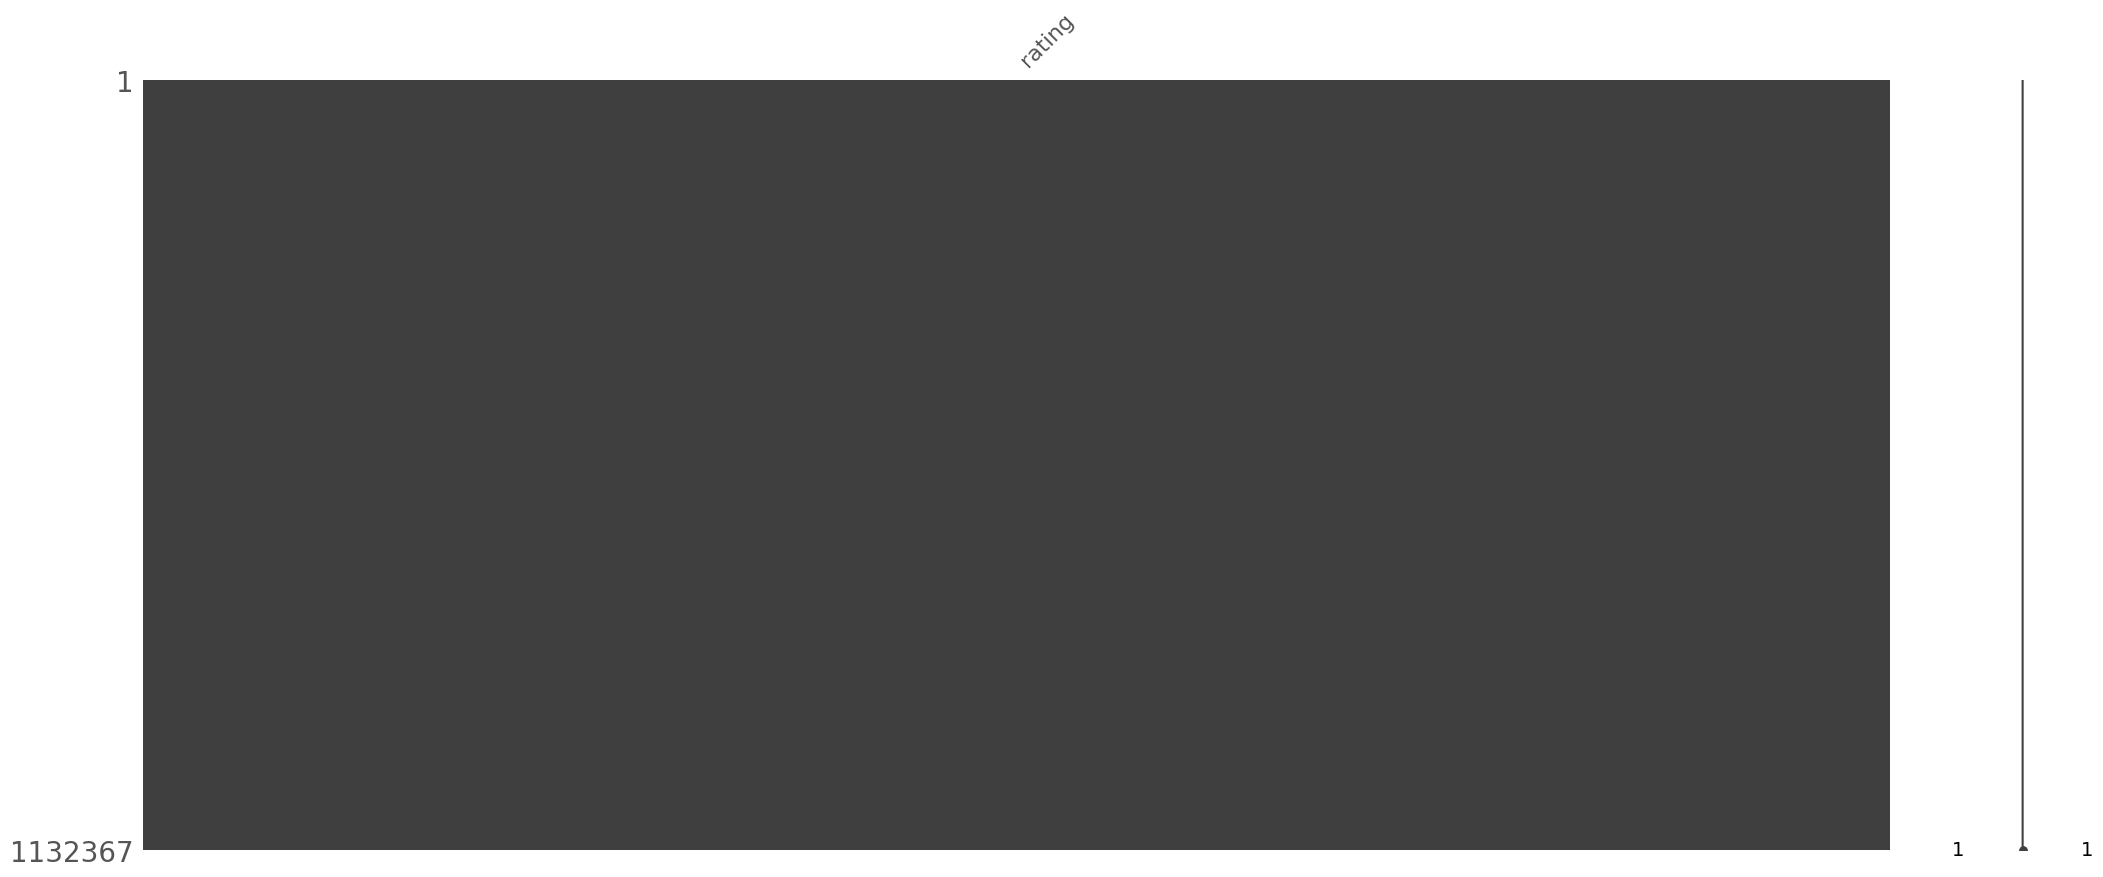

In [7]:
msno.matrix(ratings_)

In [8]:
raw_recipes_.head()

,name,minutes,nutrition,n_steps,ingredients,n_ingredients
id,,,,,,
137739,arriba baked winter squash mexican style,55,"[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['winter squash', 'mexican seasoning', 'mixed ...",7
31490,a bit different breakfast pizza,30,"[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['prepared pizza crust', 'sausage patty', 'egg...",6
112140,all in the kitchen chili,130,"[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['ground beef', 'yellow onions', 'diced tomato...",13
59389,alouette potatoes,45,"[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,"['spreadable cheese with garlic and herbs', 'n...",11
44061,amish tomato ketchup for canning,190,"[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,"['tomato juice', 'apple cider vinegar', 'sugar...",8


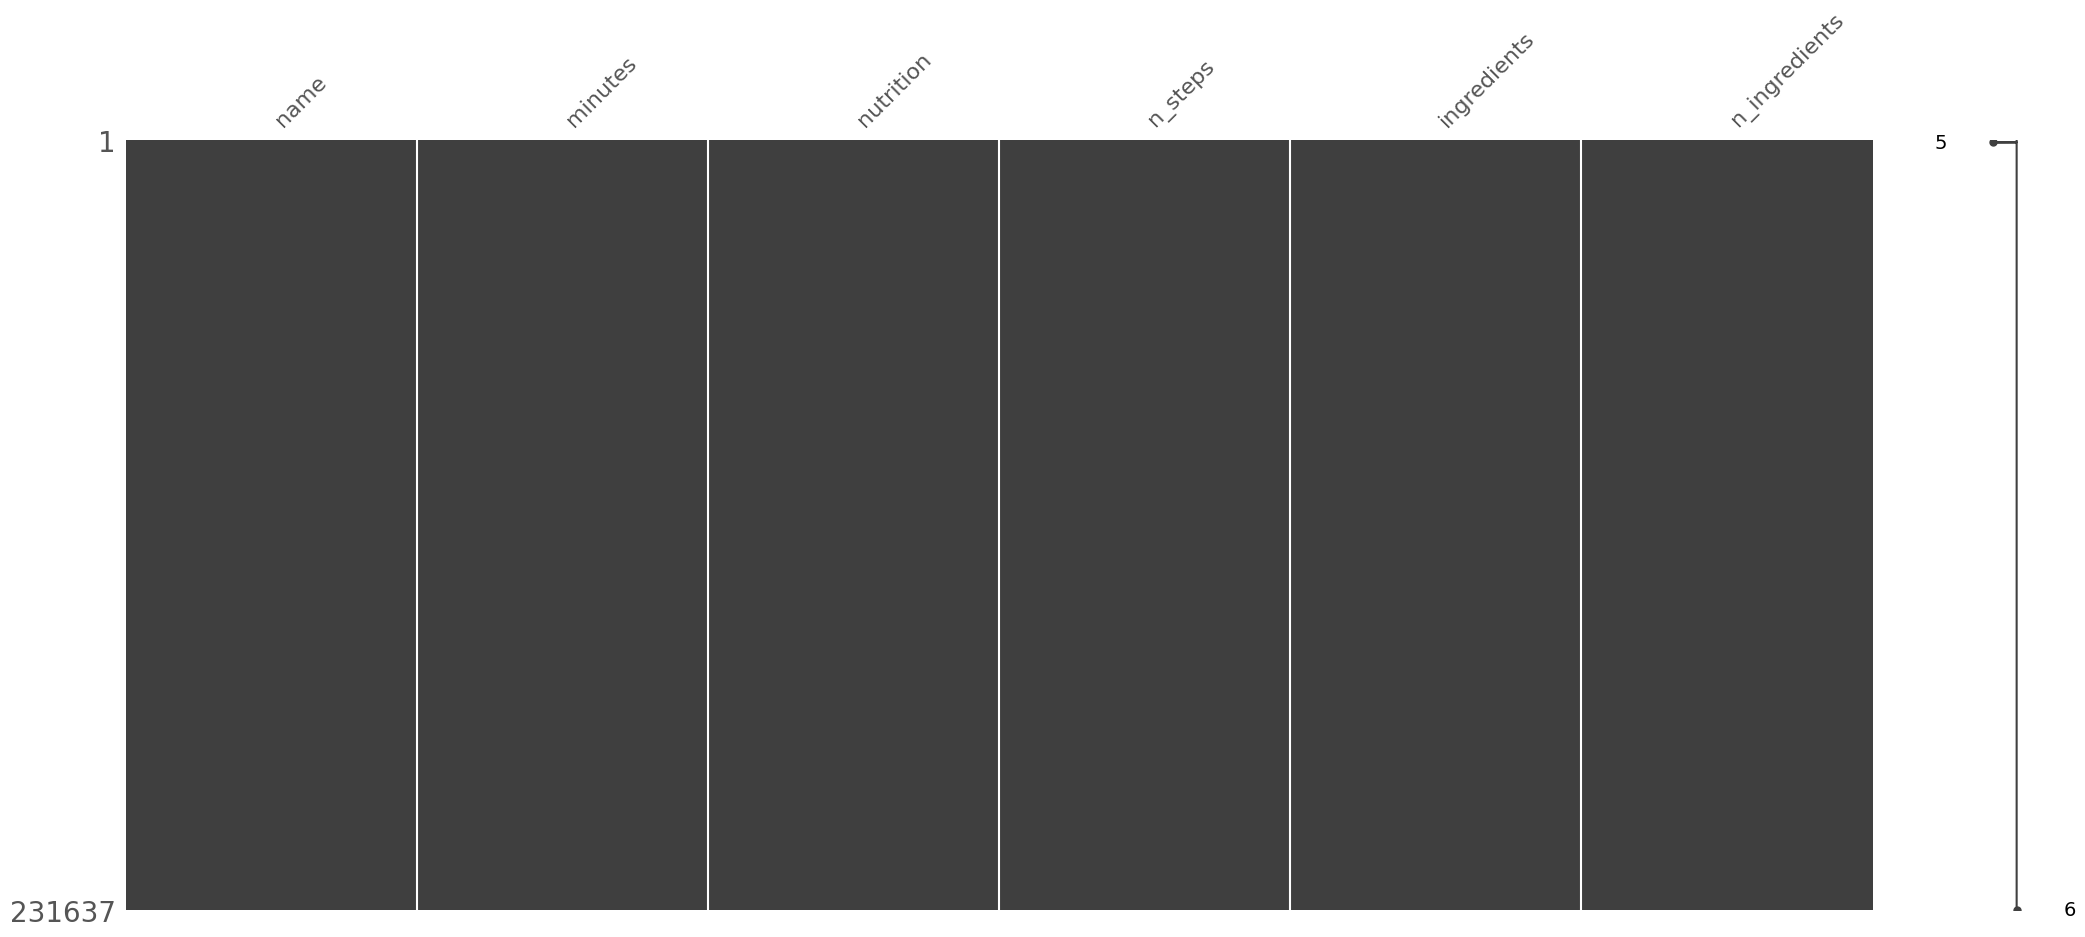

In [9]:
msno.matrix(raw_recipes_);

In [10]:
recipes_.head()

,techniques,calorie_level,ingredient_ids
id,,,
424415,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",0,"[389, 7655, 6270, 1527, 3406]"
146223,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",0,"[2683, 4969, 800, 5298, 840, 2499, 6632, 7022,..."
312329,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",1,"[1257, 7655, 6270, 590, 5024, 1119, 4883, 6696..."
74301,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,"[7940, 3609, 7060, 6265, 1170, 6654, 5003, 3561]"
76272,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",0,"[3484, 6324, 7594, 243]"
...,...,...,...
323143,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,"[840, 208, 2499, 2683, 1925, 335, 1511]"
149114,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,"[2499, 4717, 1168, 6270, 6324, 7040]"
34200,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",2,"[2378, 7655, 3219, 2320, 5168, 5319, 4189, 268..."


<Axes: >

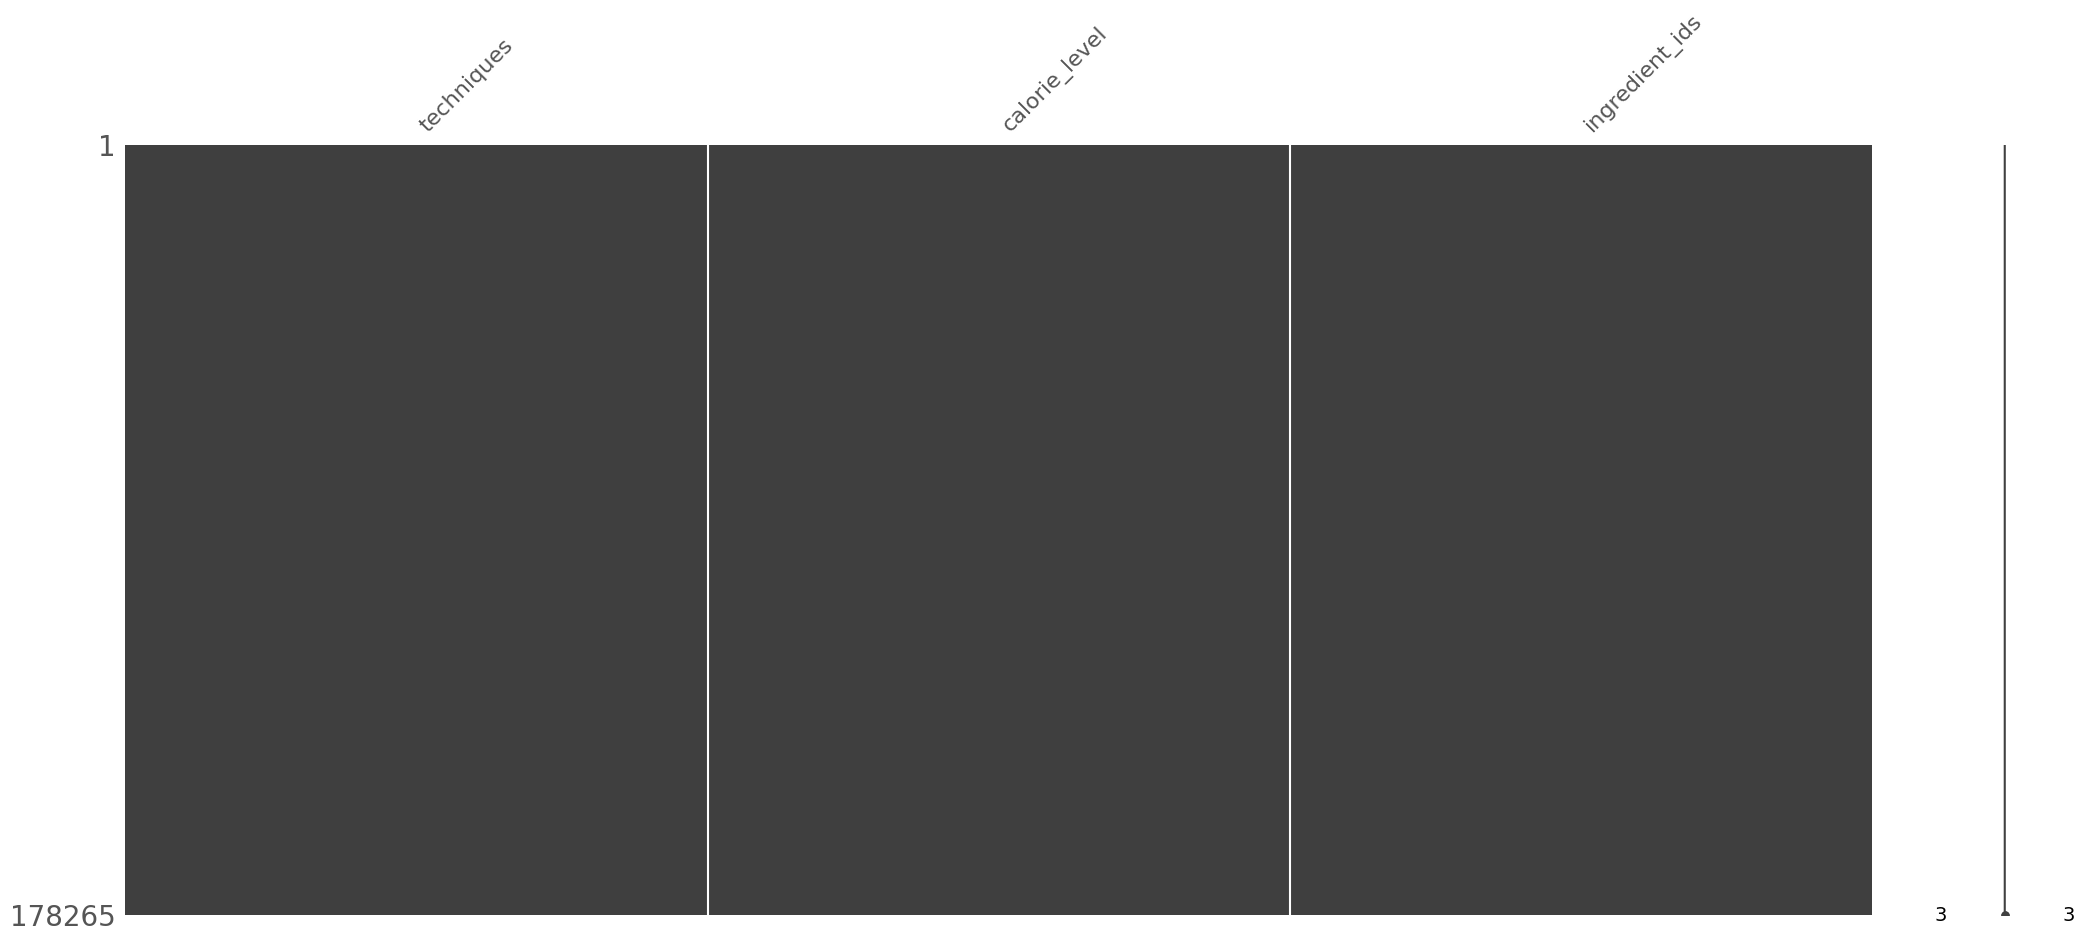

In [11]:
msno.matrix(recipes_)

<h3>Ratings</h3>

In [12]:
def timer_func(func):
    '''Wrapper function to time functions'''
    def wrap_func(*args, **kwargs):
        t1 = time()
        result = func(*args, **kwargs)
        t2 = time()
        print(f'Function {func.__name__!r} executed in {(t2-t1):.4f}s')
        return result
    return wrap_func

In [13]:
#checking for outliers
print(f'Count of ratings > 5: {(ratings_ > 5).sum()[0]}')
print(f'Count of ratings < 0: {(ratings_ < 0).sum()[0]}')

Count of ratings > 5: 0
Count of ratings < 0: 0


In [14]:
#two methods for re-scaling reviews based on review number 

#bayesian ci
def bayes_ci(n,rating,alpha=0.95):
    '''Function to find Bayesian confidence interval'''
    mean,_,_ = bayes_mvs(n,alpha)
    return mean.statistic

#bayesian average
avg = ratings_.mean()
count = ratings_.count()
C = (ratings_.reset_index().groupby('recipe_id').agg('size').sort_values().quantile(.25))
m = ratings_.mean().rating

#bayesian average
def bayes_avg(n,C=C,m=m):
    '''Function to find Bayesian average'''
    avg = n.mean()
    count = n.count()
    return (avg*count+C*m)/(count+C)

In [15]:
@timer_func
def scale_ratings(ratings):
    '''Function to scale ratings'''
    ratings = ratings.reset_index()
    ratings = ratings.groupby('recipe_id').agg({'rating':bayes_avg})
    return ratings

In [16]:
@timer_func
def scale_ratings_dask(ratings):
    '''Scale ratings based on rating number'''
    import dask.dataframe as dd
    import dask
    ratings = dd.from_pandas(ratings.reset_index(),npartitions=10)
    ratings = ratings.repartition(partition_size="100MB")
    ratings = ratings.groupby('recipe_id').rating.apply(bayes_avg).compute()
    #ratings = df.set_index('name').persist()
    #result = ratings.groupby('recipe_id')
    return ratings

In [17]:
_, _, ratings_ = import_data()   

In [18]:
scale_ratings_dask(ratings_)

/tmp/ipykernel_233924/2033962719.py:8: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  ratings = ratings.groupby('recipe_id').rating.apply(bayes_avg).compute()


Function 'scale_ratings_dask' executed in 8.8038s


recipe_id
38        4.282203
39        3.705508
40        4.341102
41        4.470339
43        2.705508
            ...   
537459    4.705508
537485    4.705508
537543    2.205508
537671    2.205508
537716    4.705508
Name: rating, Length: 231637, dtype: float64

<h4>Encoding and normalizing features</h4>

In [19]:
def scale_column(df,key):
    '''function to scale columns'''
    scaler = StandardScaler()
    return pd.DataFrame(scaler.fit_transform(np.array(df[key]).reshape(-1,1)),columns=[key])

In [20]:
cols_to_normalize = ['calorie_level','minutes','n_steps','n_ingredients','rating']

def normalize_select_cols(df,cols_to_normalize):
    '''normalizes selected columns'''
    for col in cols_to_normalize:
        df[col] = scale_column(df,col).values
    return df

<h3>Creating clustering dataset</h3>

In [21]:
def merge_frames(recipes,raw_recipes, ratings):
    '''merging data into single usable df'''
    return recipes.merge(raw_recipes[['minutes','nutrition','n_steps','n_ingredients']],how='inner',left_index=True,right_index=True).merge(ratings,how='inner',left_index=True,right_index=True)

In [22]:
def string_to_list(s):
    '''Converts a string that is formatted like a list to a list'''
    l = re.findall(r'\d+',s)
    l = [int(num) for num in l]
    return l

In [23]:
def get_top(recipes=recipes_,n_ingred=2000,show=False):
    '''Generates list of top ingredients'''
    if isinstance(recipes['ingredient_ids'].iloc[0],str):
        ingred = recipes['ingredient_ids'].apply(string_to_list)
    else: ingred = recipes['ingredient_ids']
    ingred = list(itertools.chain.from_iterable(ingred))
    total_num_ingred = len(Counter(ingred))
    if show:
        print(f'Total ingredient number: {total_num_ingred}')
    ingred_counts = Counter(ingred).most_common(n_ingred)
    top_ingredients = [ingred_counts[n][0] for n in range(len(ingred_counts))]
    return total_num_ingred, top_ingredients

In [24]:
total_num_ingred, top_ingredients = get_top(show=True)

Total ingredient number: 7993


In [26]:
@timer_func
def trim_ingredients(recipes,size=None,top_ingredients=top_ingredients):
    '''Filters ingredients that aren't in top ingredient list'''
    if not size:
        size = recipes['ingredient_ids'].shape[0]
        #print(size)

    ingredient_list = deque([])

    for n in range(size): #df[1].shape[0]):
        test=string_to_list(recipes['ingredient_ids'].iloc[n])
        selected = [i for i in test if i in top_ingredients]
        ingredient_list.append(selected)
    recipes = recipes.iloc[:size,:]
    recipes['ingredient_ids']=ingredient_list
    return recipes

In [27]:
@timer_func
def transform_to_sparse(df,key,size,encoded=False,sparse=True):
    '''Convert on column of lists to encoded columns'''
    if isinstance(df[key].iloc[0],str):
        data = df[key].apply(string_to_list)
    else: data = df[key]
    t_names = [str(n)+' '+key for n in range(size)]
    data = pd.DataFrame(data.to_list(), columns=t_names,index=df.index.values)
    if encoded:
        return data 
    else: 
        #dask not working with lists
        #import dask.dataframe as dd 
        #ddf = dd.from_pandas(df[key].astype('category'),npartitions=10)
        #data = dd.get_dummies(ddf).compute()
        data = pd.get_dummies(data.stack(),sparse=sparse)
        data = data.groupby(level=0).sum()
    return data

In [28]:
@timer_func
def encode_all(df,keys,sizes,encoded=False,sparse=True):
    '''Convert all keyhs to encoded columns'''
    #encode
    encoded_data = []
    for n,key in enumerate(keys):
        data = transform_to_sparse(df,key,sizes[n],encoded[n],sparse[n])
        #delete original columns
        try:
            df.pop(key)
        except:
            pass
    encoded_data.append(data)
    return encoded_data

In [29]:
@timer_func
def concat_df(g):
    '''Concatenate encoded and non-encoded data'''
    df = pd.concat(g)
    return df

<h3>Data cleaning pipeline</h3>

In [30]:
#class to do all 
@timer_func
class CleanAndTransform():
    def __init__(self,n_ingred=1000,test_size=None):
        #data attributes
        self.keys  = ['techniques','ingredient_ids','nutrition']
        self.sizes = (58,20,14)
        self.encoded = (True,False,False)
        self.sparse = (True,True,True)
        self.cols_to_normalize = ['calorie_level','minutes','n_steps','n_ingredients','rating']
        
        #contorl output dimensions
        self.n_ingred = n_ingred
        self.test_size = test_size

        
        #import data and scale down number of ingredients considered 
        self.recipes, self.raw_recipes, self.ratings = import_data()   
        _,self.top_ingredients = get_top(recipes=self.recipes,n_ingred=n_ingred,show=False)
        self.recipes = trim_ingredients(recipes=self.recipes,size=self.test_size,top_ingredients=self.top_ingredients)
        
        #rescale ratings
        self.ratings = scale_ratings(self.ratings)
        
        #compile results
        self.df = merge_frames(self.recipes, self.raw_recipes, self.ratings)
        self.df = normalize_select_cols(self.df,self.cols_to_normalize)
        self.df = self.df.fillna(0)


    def __call__(self):
        #encode data
        self.df = self.df[:self.test_size]
        self.g = encode_all(self.df,self.keys,self.sizes,self.encoded,self.sparse)
        df = concat_df(self.g)
        return self.g

In [31]:
try:
    with open('cleaned_data.pkl','rb') as f:
        df = pickle.load(f)
    f.close()
except:
    transform = CleanAndTransform(n_ingred=1000)
    df = transform()
    with open('cleaned_data.pkl','wb') as f:
        pickle.dump(df,f)
    f.close()

Function 'trim_ingredients' executed in 2.1740s
Function 'scale_ratings' executed in 8.3582s
Function 'CleanAndTransform' executed in 15.9899s
Function 'transform_to_sparse' executed in 2.2959s
Function 'transform_to_sparse' executed in 5208.0665s
Function 'transform_to_sparse' executed in 24364.7760s
Function 'encode_all' executed in 29575.1432s
Function 'concat_df' executed in 0.0858s


From fitting times:

Function 'trim_ingredients' executed in 2.5847s

Function 'scale_ratings' executed in 9.8217s

Function 'CleanAndTransform' executed in 18.6918s

Function 'transform_to_sparse' executed in 2.7421s

Function 'transform_to_sparse' executed in 6410.8200s

Function 'transform_to_sparse' executed in 29991.0225s

Function 'encode_all' executed in 36404.5900s

Function 'concat_df' executed in 0.0219s

<h3><br></h3>
<h3>Creating descriptive dataframe to complement cleaned data</h3>

In [36]:
#shuffle 
def shuffle_df(df):
    '''Shuffled data'''
    df = df[0]
    df_rows = np.random.permutation(df.index.values)
    df = df.reindex(df_rows)
    return df

df = shuffle_df(df)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,30933,36098,38662,40159,42951,43924,44239,45609,362729,434360
55526,True,False,False,False,False,False,False,False,True,True,...,False,False,False,False,False,False,False,False,False,False
227242,True,False,False,False,True,True,True,True,False,True,...,False,False,False,False,False,False,False,False,False,False
23140,True,True,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
312346,True,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
33553,True,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False


In [37]:
#create a reference dataset 
def make_refdf(raw_recipes,df):
    '''Makes reference df'''
    df_ref = df.merge(raw_recipes,left_index=True,right_index=True,how='left')[['name','ingredients']]
    return df_ref

df_ref = make_refdf(raw_recipes_,df)
df_ref.head()

,name,ingredients
55526,mushroom and cheese strata,"['onion', 'garlic', 'margarine', 'fresh mushro..."
227242,apple bourbon cake,"['cooking spray', 'apples', 'bourbon', 'sugar'..."
23140,navy bean soup,"['dried navy beans', 'water', 'diced tomatoes'..."
312346,no cook chocolate ice cream,"['sweetened condensed milk', 'evaporated milk'..."
33553,awesome and easy spaghetti casserole,"['butter', 'garlic clove', 'onion', 'sugar', '..."


In [38]:
df.shape, df_ref.shape

((178265, 4696), (178265, 2))

<h2> Dimensionality Reduction </h2>

In [40]:
@timer_func
def pca_reduction(df):
    '''Finds principle coponents of df preserving 95% of variance'''
    pca = PCA(n_components = 0.95,random_state=10)
    #df.columns = df[0].columns.astype(str)
    X_pca = pca.fit_transform(df)
    print('PCA reduced dimensions from ', df.shape[1],' to ',X_pca.shape[1] ,' and preserved 95\% of variance.')
    return pca, X_pca

In [170]:
try:
    with open('X_pca.pkl','rb') as f:
        _ = pickle.load(f)
        pca = _[0]
        X_pca = _[1]
    f.close()
except:
    pca, X_pca = pca_reduction(df)
    with open('X_pca.pkl','wb') as f:
        pickle.dump([pca,X_pca],f)
    f.close()

In [44]:
X_pca

array([[-8.52056994e-01, -4.97743363e-01, -1.18277282e-01, ...,
         6.35624174e-03,  5.34090689e-03,  1.04738153e-02],
       [-3.22607068e-01,  4.63345413e-01,  3.79999192e-01, ...,
        -3.81019602e-03, -6.60555422e-03, -2.36404485e-03],
       [ 6.82454536e-01, -2.78544823e-01, -4.52114328e-01, ...,
         1.00934411e-03,  1.04702799e-03,  6.59306162e-04],
       ...,
       [ 7.84956005e-02,  9.64141129e-01,  5.87247572e-02, ...,
        -7.47617196e-03, -8.99802380e-03, -8.19704486e-03],
       [-5.56240779e-01, -3.26504575e-01, -8.49109314e-03, ...,
        -2.97668434e-03, -1.37230655e-03, -1.94144099e-03],
       [-3.92330238e-02,  9.38385367e-01,  1.50810573e-01, ...,
        -1.68036618e-03, -2.68217682e-03, -4.34774265e-03]])

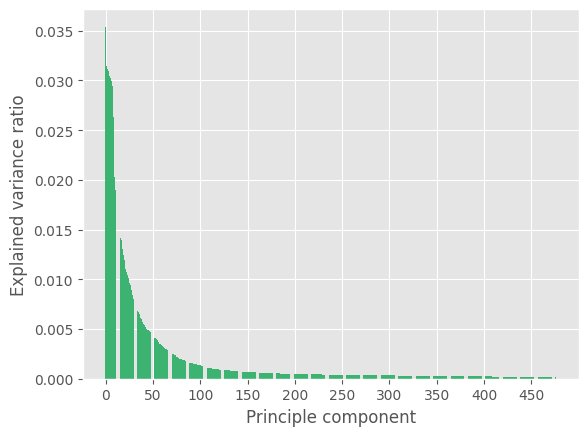

In [45]:
plt.bar(range(pca.n_components_), pca.explained_variance_ratio_,color='mediumseagreen')
plt.xlabel('Principle component')
plt.ylabel('Explained variance ratio')
plt.xticks(range(0,pca.n_components_,50));

<h2><br><h2>
<h2>Clustering</h2>
<h3>Selecting KMeans algorithm</h3>

In [171]:
X_test = X_pca

In [48]:
@timer_func
def cluster(X_pca,cluster_start=2, cluster_stop=50, cluster_skip=10):
    '''cluster data using traditional kmeans algorithm'''
    k_range = np.arange(cluster_start,cluster_stop,cluster_skip)
    kmeans = [KMeans(n_clusters = k, n_init=100, random_state=10).fit(X_pca) for k in k_range]
    inertia = [kmeans.inertia_ for kmeans in kmeans]
    labels = [kmeans.labels_ for kmeans in kmeans]
    s_scores = [silhouette_score(X_pca, kemans.labels_) for kemans in kmeans]
    return k_range, kmeans, inertia, labels, s_scores

In [49]:
@timer_func
def batch_cluster(X_pca,cluster_start=2, cluster_stop=50, cluster_skip=10):    
    '''Clusters data using mini-batch Kmeans'''
    k_range = np.arange(cluster_start,cluster_stop,cluster_skip)
    kmeans = [MiniBatchKMeans(n_clusters = k, n_init=100, random_state=10).fit(X_pca) for k in k_range]
    inertia = [kmeans.inertia_ for kmeans in kmeans]
    labels = [kmeans.labels_ for kmeans in kmeans]
    s_scores = [silhouette_score(X_pca, kemans.labels_) for kemans in kmeans]
    return k_range, kmeans, inertia, labels, s_scores

In [50]:
@timer_func
def elkan_cluster(X_pca,cluster_start=2, cluster_stop=50, cluster_skip=10):
    '''Clusters data using elkan clustering algorithm'''
    k_range = np.arange(cluster_start,cluster_stop,cluster_skip)
    kmeans = [KMeans(n_clusters = k, n_init=100, random_state=10, algorithm='elkan').fit(X_pca) for k in k_range]
    inertia = [kmeans.inertia_ for kmeans in kmeans]
    labels = [kmeans.labels_ for kmeans in kmeans]
    s_scores = [silhouette_score(X_pca, kemans.labels_) for kemans in kmeans]
    return k_range, kmeans, inertia, labels, s_scores

In [51]:
_,_,_,_,_= batch_cluster(X_test,cluster_stop=10)

Function 'batch_cluster' executed in 15.3899s


In [52]:
_,_,_,_,_ = cluster(X_test,cluster_stop=10)

Function 'cluster' executed in 18.0684s


In [53]:
_,_,_,_,_ = elkan_cluster(X_test, cluster_stop=10)

Function 'elkan_cluster' executed in 18.2541s


<h3><br></h3>
<h3>Finding cluster number</h3>

In [54]:
X_pca.shape, df.shape, X_test.shape

((178265, 477), (178265, 4696), (10000, 477))

In [172]:
k_range, kmeans, inertia, labels, s_scores = batch_cluster(X_test, cluster_stop = 20, cluster_skip = 1)

Function 'batch_cluster' executed in 12717.5958s


In [174]:
with open('cluster_size_data.pkl','wb') as f: 
    pickle.dump([k_range,kmeans,inertia,labels,s_scores],f)
f.close()

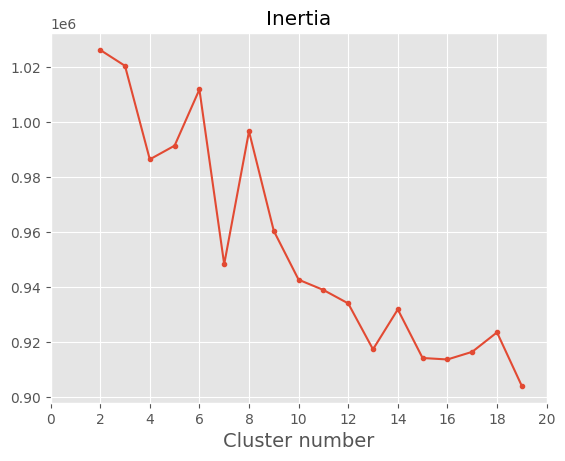

In [181]:
plt.plot(k_range,inertia,'.-')
plt.xlabel('Cluster number', fontsize=14)
#plt.ylabel('Inertia', fontsize=14)
plt.title('Inertia')
plt.xticks(np.arange(0,21,2))
plt.show()


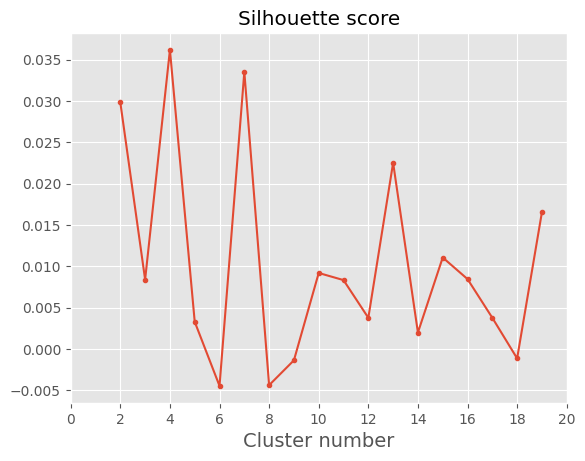

In [183]:
plt.plot(k_range,s_scores,'.-')
plt.xlabel('Cluster number', fontsize=14)
#plt.ylabel('Silhoette score', fontsize=14)
plt.xticks(np.arange(0,21,2))
plt.title('Silhouette score')
plt.show()

In [ ]:
#final fit


In [186]:
CLUSTER_NUM=7
try:
    with open('cluster_data.pkl','rb') as f:
        _ = pickle.load(f)
        k_range = _[0]
        kmeans = _[1]
        inertia = _[2]
        labels = _[3]
except:
    k_range, kmeans, inertia, labels, s_scores = cluster(X_pca, cluster_start = CLUSTER_NUM, cluster_stop=CLUSTER_NUM+1)
    with open('cluster_data.pkl','wb') as f:
        pickle.dump([k_range, kmeans,inertia,labels],f)
    f.close()

Function 'cluster' executed in 789.8265s


In [187]:
df['Cluster_ID']=labels[0]

<h2><br></h2>
<h2>Cluster properties</h2>

In [188]:
X_pca = pd.DataFrame(X_pca)
X_pca['Cluster ID'] = labels[0]

In [189]:
X_pca.groupby('Cluster ID').agg('mean').reset_index()

,Cluster ID,0,1,2,3,4,5,6,7,8,...,467,468,469,470,471,472,473,474,475,476
0,0,-0.511166,-0.094663,0.282982,-0.170836,0.412998,-0.405259,0.129397,0.139556,0.162776,...,9.782338e-05,0.000063,-0.000101,0.000044,-0.000154,0.000024,-0.000016,0.000073,-0.000277,-0.000006
1,1,-0.171145,0.777672,-0.086583,0.083015,-0.148497,0.059187,-0.070773,0.127192,0.034712,...,-7.766139e-06,-0.000102,0.000068,-0.000144,0.000027,-0.000076,-0.000161,-0.000072,0.000132,0.000097
2,2,0.365873,-0.041523,-0.384952,-0.361045,0.060545,-0.098134,-0.036978,-0.424572,0.122736,...,-5.484452e-05,-0.000087,-0.000026,-0.000005,0.000047,-0.000093,-0.000003,-0.000143,-0.000030,-0.000112
3,3,-0.349873,-0.133637,-0.114674,-0.136419,0.044827,0.390784,0.181938,0.039206,-0.274134,...,-9.277744e-07,0.000197,0.000139,0.000313,-0.000113,-0.000011,0.000004,0.000375,0.000108,0.000117
4,4,0.170063,-0.204909,-0.120264,-0.178765,0.089921,-0.017127,-0.310454,0.717257,-0.140599,...,-8.290457e-05,-0.000363,0.000110,-0.000194,0.000019,0.000333,0.000049,0.000068,-0.000051,0.000099
5,5,-0.031494,-0.175953,-0.221604,0.758589,0.005108,-0.093799,0.068842,0.008315,0.018199,...,-1.231693e-05,0.000017,-0.000020,-0.000043,0.000068,-0.000012,0.000115,-0.000109,-0.000087,-0.000072
6,6,0.275145,-0.111059,0.639158,-0.006727,-0.304708,0.099195,-0.033194,-0.132425,0.012122,...,5.624784e-05,0.000145,-0.000108,-0.000028,0.000049,-0.000012,0.000007,-0.000078,0.000125,-0.000029


<h2><br></h2>
<h2>Visualising clusters</h2>
<h3>Principle components</h3>

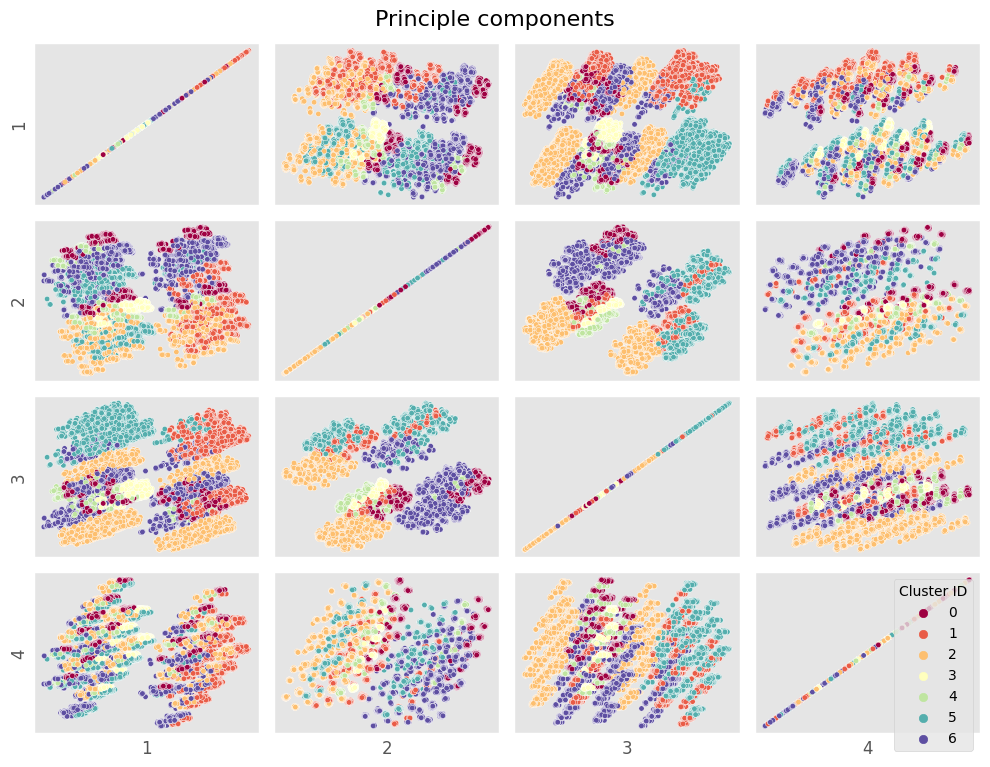

In [190]:
#plotting
plt.figure(figsize=(10,8))
pcas = 4
count = 1
plt.suptitle('Principle components',fontsize=16)
for row in range(1,pcas+1):
    for col in range(1,pcas+1):
        plt.subplot(pcas,pcas,count)
        sns.scatterplot(data=X_pca, x=col, y=row, hue='Cluster ID',palette='Spectral', legend=False, s=15)
        plt.xticks([])
        plt.yticks([])
        plt.xlabel('')
        plt.ylabel('')
        if row == pcas:
            plt.xlabel(str(col))
        if col == 1:
            plt.ylabel(str(row))
        if (col == pcas)&(row==pcas):
            sns.scatterplot(data=X_pca, x=row, y=col, hue='Cluster ID',palette='Spectral', legend=True, s=15)
        count += 1
plt.tight_layout()

<h3><br></h3>
<h3>TSNE</h3>

In [ ]:
X_embeded = TSNE(n_components=2,n_jobs=-1).fit_transform(X_pca.to_numpy())

In [ ]:
Xem = pd.DataFrame(X_embeded,columns=['1','2'])
Xem['Cluster ID'] = labels[0]
Xem

In [ ]:
sns.scatterplot(data=Xem, x='1',y='2',hue='Cluster ID',palette='Spectral')

<h3><br></h3>
<h3>Word clouds</h3>

In [191]:
df_ref['Cluster ID'] = labels[0]
df_ref

,name,ingredients,Cluster ID
55526,mushroom and cheese strata,"['onion', 'garlic', 'margarine', 'fresh mushro...",0
227242,apple bourbon cake,"['cooking spray', 'apples', 'bourbon', 'sugar'...",1
23140,navy bean soup,"['dried navy beans', 'water', 'diced tomatoes'...",2
312346,no cook chocolate ice cream,"['sweetened condensed milk', 'evaporated milk'...",0
33553,awesome and easy spaghetti casserole,"['butter', 'garlic clove', 'onion', 'sugar', '...",0
...,...,...,...
361133,maple spice french toast sticks,"['eggs', 'powdered sugar', 'milk', 'maple syru...",1
99034,best ever summer strawberry spinach salad,"['baby spinach leaves', 'romaine lettuce', 'eg...",0
323582,a couple of tipsy chicks,"['cornish hens', 'light rum', 'fresh lime juic...",1
247129,wok seared chicken with asparagus and pistachos,"['toasted sesame oil', 'asparagus', 'boneless ...",0


In [302]:
#df_ref['Cluster ID']= labels[0]
CLUSTER_NUM = 7
count = 1

common_list = ['garlic clove','olive oil','garlic','olive','black pepper','s']
def filter_common(x, common_list=common_list):
    if (x in common_list):
        return False 
    else: return True

def show_cloud(df_ref,key):
    plt.figure(figsize=(6,10))
    for k in range(CLUSTER_NUM):
        df_k = df_ref[df_ref['Cluster ID']==k][key]
        list_k = df_k.to_list()
        cluster_ingred = ''
        for ingredients in list_k:
            list_kk = re.findall(r'(\w[\w\s]+)',ingredients)
            list_kk = filter(filter_common, list_kk)
            cleaned_ingredients = ' '.join(list_kk)
            cluster_ingred += cleaned_ingredients+' '
        wordcloud = WordCloud().generate(cluster_ingred)
        plt.subplot(5,2,k+1)
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'k={k+1}')
    plt.tight_layout()

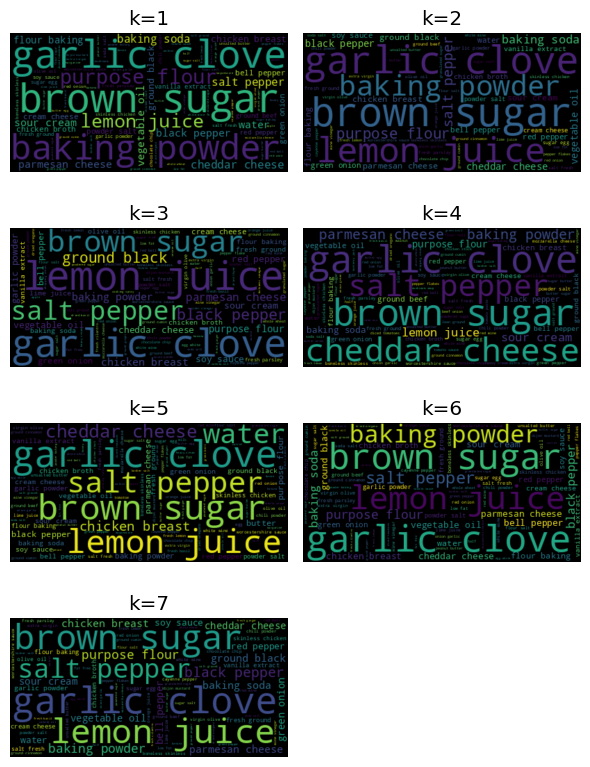

In [303]:
show_cloud(df_ref,'ingredients')

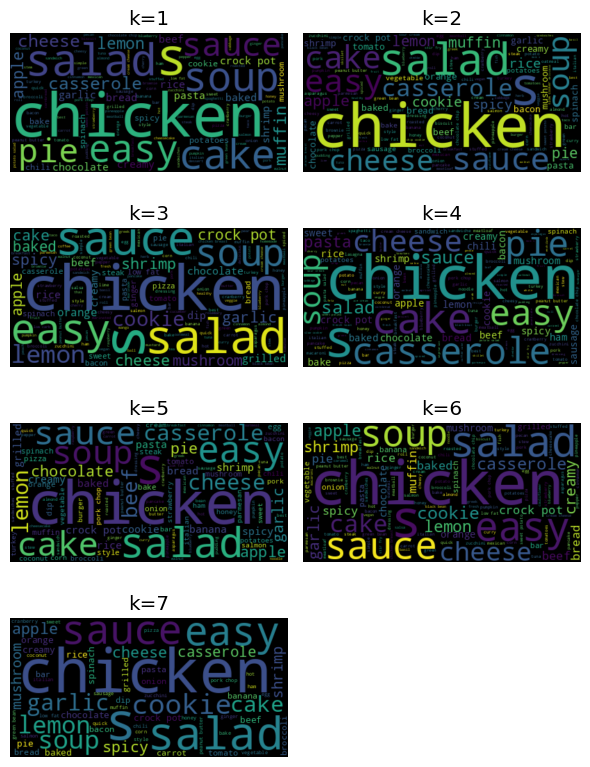

In [304]:
show_cloud(df_ref,'name')